In [23]:
import matplotlib.pyplot as plt
import ruptures as rpt
import pandas as pd
import numpy as np
import ngs_player_tracking as ngs


(1000, 3)
[188, 394, 596, 800, 1000]


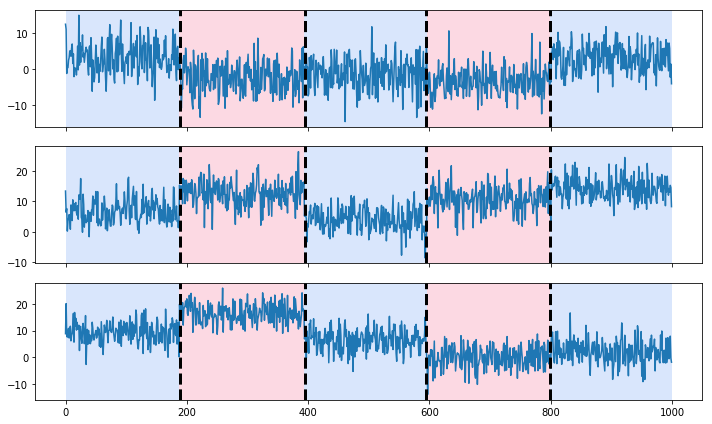

In [17]:
# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)
print (signal.shape)
print (bkps)
# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)
# display
rpt.display(signal, bkps, result)
plt.show()

## With player tracking data

In [45]:
def convert_time_to_seconds(time_str):
    """ Convert string time HH:MM:SS.ms to a seconds float """
    return 3600*int(time_str[0:2])+60*int(time_str[3:5])+int(time_str[6:8])+float(time_str[8:])

def get_velocity_list(positions, timesteps, units='m/s'):
    """
    Calculate a velocity given the list of xy as [(x0,y0),(x1,y1),..] and timesteps as [t0,t1,t2]
    velocity at t0 will be 0
    """

    velocity_list = []
    velocity_list.append((0,0))
    for i in range(len(positions) - 1):
        pos1 = positions[i]
        pos2 = positions[i+1]
        v = get_velocity(pos1, pos2, timesteps[i], timesteps[i+1])
        velocity_list.append(v)

    return velocity_list

def get_velocity(pos_1, pos_2, time_1, time_2, units='m/s'):
    """
    Calculate a velocity given two positions
    """

    #vx = field_x_meters * float(pos_2[0] - pos_1[0]) / float(abs(time_2 - time_1))
    #vy = field_x_meters * float(pos_2[1] - pos_1[1]) / float(abs(time_2 - time_1))
    if time_2==time_1:
        return (0, 0)
    else:
        vx = float(pos_2[0] - pos_1[0]) / float(abs(time_2 - time_1))
        vy = float(pos_2[1] - pos_1[1]) / float(abs(time_2 - time_1))

    return (vx, vy)

def get_ball_velocity(json_file_path):
    """
    Using this to test out a methodology for programatically getting hike and dead ball time marks
    In theory, the ball should be stationary at the hike, and maybe it reaches another stopped point at, or nearly after the dead ball whistle
    """
    print (json_file_path)
    df_all_tracking, times = ngs.extract_player_tracking_data(json_file_path)
    df_filtered = df_all_tracking[df_all_tracking['player_id']=='ball'].sort_values(by='time')
    df_filtered['time_val'] = df_filtered['time'].apply(lambda x: convert_time_to_seconds(x))
    df_filtered.to_csv('./jupyter-notebook-testing-df.csv')

    all_velocities = {}
    xpos = np.array(df_filtered['x'])
    ypos = np.array(df_filtered['y'])
    positions = list(zip(xpos, ypos))
    timesteps = np.array(df_filtered['time_val'])
    velocities = get_velocity_list(positions, timesteps)
    indices = list(df_filtered.index)
    all_velocities = {**all_velocities, **dict(zip(indices, velocities))}

    #  Compile the velocity data structures of all players and add it to the dataframe
    df_filtered['velocity'] = df_filtered.index.to_series().map(all_velocities)
    df_filtered['speed'] = df_filtered['velocity'].apply(lambda x: (x[0]**2 + x[1]**2)**0.5)

    ## Using ruptures library
    speed_signal = np.array(df_filtered['speed']).reshape(-1,1)
    speed_breakpts = 2
    speed_detection = rpt.Pelt(model="rbf").fit(speed_signal)
    speed_result = speed_detection.predict(pen=10)

    # display
    rpt.display(speed_signal, [], speed_result)
    plt.show()
    
    return speed_result[:-1], [list(df_filtered['time'])[x] for x in speed_result[:-1]]


Index(['Unnamed: 0', 'play_id', 'description', 'time', 'player_id', 'team',
       'team_nfl', 'x', 'y', 'time_val', 'velocity', 'speed'],
      dtype='object')
(325, 12)
(325, 1)
[155, 250, 325]


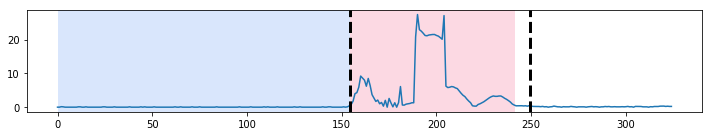

In [22]:
example_csv = 'C:/Users/572784/Documents/Personal/Sports Analytics/play_tracking_cv/ball_velocity.csv'

df = pd.read_csv(example_csv)
print (df.columns)
print (df.shape)

speed_signal = np.array(df['speed']).reshape(-1,1)
print (speed_signal.shape)
speed_breakpts = 2

# predict
speed_detection = rpt.Pelt(model="rbf").fit(speed_signal)
speed_result = speed_detection.predict(pen=10)
print (speed_result)

# display
rpt.display(speed_signal, [155,242], speed_result)
plt.show()

D:/Sports Analytics/sportradar/redskins-colts-week2/8bdf2871-5ec6-4966-8e29-ba43df1b3414.json


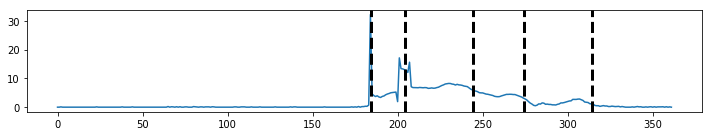

In [53]:
## This play is an interception, and the second break (140), is when it is picked off, 3rd one (165) is ~when he's tackled
json_to_examine = 'D:/Sports Analytics/sportradar/eagles-bucs-week2/003f27f0-0e4c-47e4-bd66-78aaede177f7.json'

## This one had a division by zero here from this line: vx = float(pos_2[0] - pos_1[0]) / float(abs(time_2 - time_1))
# added in a check for time_2==time_1, and just returning v=(0, 0)
json_to_examine = 'D:/Sports Analytics/sportradar/eagles-bucs-week2/0307ce31-aa17-4985-a0c4-9a01f1783af9.json'

# This play didn't have any tracking data for the ball, must have been an NGS error
# just removed this from the file path, there was also another one, and both are here:
#  D:\Sports Analytics\error plays
json_to_examine = 'D:/Sports Analytics/sportradar/ravens-bengals-week2/006b59fd-3a0c-4a46-939e-d0c0a1751fbe.json'

# Only had 1 break point returned
json_to_examine = 'D:/Sports Analytics/sportradar/ravens-bengals-week2/fd4e2ebd-a04a-46e6-8fca-4fdd45c77457.json'

# Wanted to look at a rushing example
json_to_examine = 'D:/Sports Analytics/sportradar/ravens-bengals-week2/f9c57bf0-672e-4865-be85-a4e373b010f2.json'

# Wanted to look at a play with 5 predicted breaks
json_to_examine = 'D:/Sports Analytics/sportradar/redskins-colts-week2/8bdf2871-5ec6-4966-8e29-ba43df1b3414.json'

break_idx, break_times = get_ball_velocity(json_to_examine)

### Breakdown of how to use the rupture change points

Here's the counts of plays with N number of predicted breakpoints
   * 0 Break(s): 8
   * 1 Break(s): 123
   * 2 Break(s): 290
   * 3 Break(s): 144
   * 4 Break(s): 41
   * 5 Break(s): 10
   * 6 Break(s): 2
   * 7 Break(s): 2
   
If N==0: then don't use this image
   * D:/Sports Analytics/sportradar/eagles-bucs-week2/75025507-9453-4ae2-8a01-1d217098d94f.json
   * D:/Sports Analytics/sportradar/eagles-bucs-week2/97378551-6d0b-4158-b66c-f30a01c09b9a.json
   * D:/Sports Analytics/sportradar/eagles-bucs-week2/e4f0bc6e-e6f3-47b7-add9-217a9824566d.json
   * D:/Sports Analytics/sportradar/jaguars-patriots-week2/c9a6c164-3147-40c4-986f-4b1b2a4cdc43.json
   * D:/Sports Analytics/sportradar/redskins-colts-week2/662aaa44-cef5-4133-b284-4d8a20e04317.json
   * D:/Sports Analytics/sportradar/redskins-colts-week2/7e027bd0-2a56-4541-9835-f43ceeba28a4.json
   * D:/Sports Analytics/sportradar/redskins-colts-week2/8605d257-33ea-4707-b7cf-80400c5bc956.json
   * D:/Sports Analytics/sportradar/redskins-colts-week2/c49793e5-6749-46cb-90cd-0f0e64d737da.json

If N==1: then use that as the hike/start, and the last time as the end

If N==2: good to go

If N==3+, use the 3rd one for all of them